In [1]:
import numpy as np

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.getcwd()+"\\tensorflow-glove")
sys.path.append(os.getcwd())
import data_helpers
import tf_glove
import nltk
from helpers import *

In [2]:
positive_data_file = "./data/twitter-datasets/train_pos.txt"
negative_data_file = "./data/twitter-datasets/train_neg.txt"
embedding_dim = 128

In [3]:
x_text, y = data_helpers.load_data_and_labels(positive_data_file, negative_data_file) # Build vocabulary
y = np.array([1 if li[0]==0 else 0 for li in y])

In [4]:
corpus_glove = (nltk.wordpunct_tokenize(tweet) for tweet in x_text)
glove_model = tf_glove.GloVeModel(embedding_size=embedding_dim, context_size=10, min_occurrences=15,
                                        learning_rate=0.05, batch_size=512)
glove_model.fit_to_corpus(corpus_glove)
glove_model.train(num_epochs=50)


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [5]:
def getTweetEmbedding(tweet, glove, embedding_size):
    tweet_embedding = np.zeros(embedding_size).reshape((1,embedding_size))
    nbr_tokens = len(tweet)
    for token in tweet:
        tweet_embedding +=glove.embedding_for(token)
    if nbr_tokens>0:
        tweet_embedding /= nbr_tokens
    return tweet_embedding

In [6]:
tweet_embeddings = np.concatenate([getTweetEmbedding(nltk.wordpunct_tokenize(tweet), glove_model, 128) for tweet in x_text])
x = tweet_embeddings

In [7]:
def get_accuracies(y, x, hparams, loss='log', penalty='l2', seed=1):
    k_fold = len(hparams)
    seed = 1
    k_indices = build_k_indices(y.shape[0], k_fold, seed)
    acc = []
    for k, hparam in enumerate(hparams):
        model= SGDClassifier(loss=loss, penalty=penalty, alpha=hparam, fit_intercept=False)
        test_idx = k_indices[k,:]
        row_idx = list(range(k_indices.shape[0]))
        train_idx = k_indices[row_idx[:k]+row_idx[k+1:],:].flatten()
        y_train, x_train = y[train_idx], x[train_idx, :]
        y_dev, x_dev = y[test_idx], x[test_idx, :]
        x_train, mean_x, std_x = standardize(x_train)
        x_dev, _, _ = standardize(x_dev, mean_x=mean_x, std_x=std_x)
        model.fit(x_train, y_train)
        acc.append(model.score(x_dev, y_dev))
    return acc

In [8]:
models = [['log','elasticnet'],['hinge','elasticnet'], ['modified_huber', 'l2'], ['perceptron', 'l2']]
lambdas = np.logspace(-5, 2, 20)


all_acc = [get_accuracies(y, x, lambdas, loss=loss, penalty=penalty) for loss, penalty in models]


Populating the interactive namespace from numpy and matplotlib


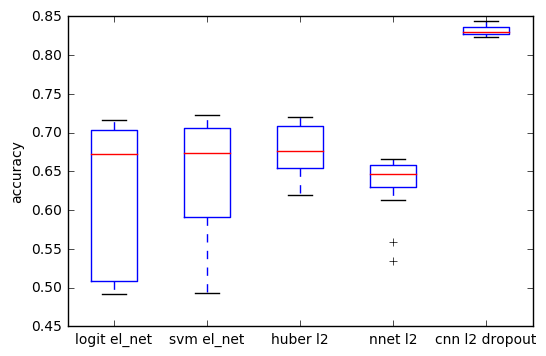

In [24]:
import numpy as np
import matplotlib.pyplot as plt

#run ./cnn_cross.py --channels "glove"  (in the command line)
#hyper parameters can be changed in cnn_cross.py as well as frequency of dev evaluation
all_acc = all_acc[:4]
models = models[:4]
all_acc.append(list(np.load('accs_cnn.npy')))
models.append(['cnn', 'l2 dropout'])
name = {'log':'logit', 'elasticnet': 'el_net', 'hinge':'svm',
        'modified_huber':'huber', 'l1':'l1', 'l2':'l2', 'perceptron':'nnet','cnn':'cnn', 'l2 dropout':'l2 dropout'}

%pylab inline
plt.ylabel('accuracy')
plt.boxplot(all_acc)
plt.xticks(range(1, len(models) + 1) ,['%s %s'%(name.get(loss), name.get(penalty)) for loss, penalty in models])
plt.savefig('baseline_boxplt.jpg', format='jpeg')